Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.8`. To run this notebook example, please install flaml with the `automl` option (this option is introduced from version 2, for version 1 it is installed by default):
```bash
pip install flaml[automl]
```

In [1]:
# %pip install flaml[automl] matplotlib openml

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [3]:
from minio.error import ServerError
from flaml.data import load_openml_dataset

try:
    X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')
except (ServerError, Exception):
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from pandas import DataFrame

    X, y = make_classification(n_samples=539383, n_features=7)
    X = DataFrame(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)


download dataset from openml
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


In [4]:
X_train.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length
249392,EV,5309.0,MDT,ATL,3,794.0,131.0
166918,CO,1079.0,IAH,SAT,5,900.0,60.0
89110,US,1636.0,CLE,CLT,1,530.0,103.0
70258,WN,928.0,CMH,LAS,7,480.0,280.0
492985,WN,729.0,GEG,LAS,3,630.0,140.0


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default classifiers are `['lgbm', 'xgboost', 'xgb_limitdepth', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [5]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [6]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}


In [7]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 04-28 02:20:40] {1663} INFO - task = classification
[flaml.automl.logger: 04-28 02:20:40] {1670} INFO - Data split method: stratified
[flaml.automl.logger: 04-28 02:20:40] {1673} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-28 02:20:40] {1771} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-28 02:20:41] {1881} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-28 02:20:41] {2191} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-28 02:20:41] {2317} INFO - Estimated sufficient time budget=44511s. Estimated necessary time budget=1093s.
[flaml.automl.logger: 04-28 02:20:41] {2364} INFO -  at 1.2s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[flaml.automl.logger: 04-28 02:20:41] {2191} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-28 02:20:41] {2364} INFO -  at 1.2s,	estimato

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.2s,	estimator extra_tree's best error=0.3787,	best estimator lgbm's best error=0.3550
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 14, current learner rf
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.2s,	estimator rf's best error=0.3816,	best estimator lgbm's best error=0.3550
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 15, current learner rf
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.3s,	estimator rf's best error=0.3791,	best estimator lgbm's best error=0.3550
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 16, current learner lgbm
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.4s,	estimator lgbm's best error=0.3550,	best estimator lgbm's best error=0.3550
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 17, current learner xgboost
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.4s,	estimator xgboost's best error=0.3699

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.7s,	estimator lgbm's best error=0.3545,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 19, current learner xgboost
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.8s,	estimator xgboost's best error=0.3596,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 20, current learner xgboost
[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.8s,	estimator xgboost's best error=0.3596,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 21, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:42] {2364} INFO -  at 2.9s,	estimator xgboost's best error=0.3596,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:42] {2191} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 04-28 02:20:43] {2364} INFO -  at 3.1s,	estimator lgbm's best error=0.3545,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:43] {2191} INFO - iteration 23, current learner lgbm
[flaml.automl.logger: 04-28 02:20:43] {2364} INFO -  at 3.6s,	estimator lgbm's best error=0.3545,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:43] {2191} INFO - iteration 24, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:43] {2364} INFO -  at 3.9s,	estimator xgboost's best error=0.3586,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:43] {2191} INFO - iteration 25, current learner xgboost
[flaml.automl.logger: 04-28 02:20:44] {2364} INFO -  at 4.0s,	estimator xgboost's best error=0.3577,	best estimator lgbm's best error=0.3545
[flaml.automl.logger: 04-28 02:20:44] {2191} INFO - iteration 26, current learner lgbm


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:44] {2364} INFO -  at 4.1s,	estimator lgbm's best error=0.3536,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:44] {2191} INFO - iteration 27, current learner rf
[flaml.automl.logger: 04-28 02:20:44] {2364} INFO -  at 4.2s,	estimator rf's best error=0.3791,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:44] {2191} INFO - iteration 28, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:44] {2364} INFO -  at 4.7s,	estimator xgboost's best error=0.3561,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:44] {2191} INFO - iteration 29, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:44] {2364} INFO -  at 4.9s,	estimator xgboost's best error=0.3561,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:44] {2191} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 04-28 02:20:45] {2364} INFO -  at 5.2s,	estimator lgbm's best error=0.3536,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:45] {2191} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 04-28 02:20:45] {2364} INFO -  at 5.6s,	estimator lgbm's best error=0.3536,	best estimator lgbm's best error=0.3536
[flaml.automl.logger: 04-28 02:20:45] {2191} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 04-28 02:20:46] {2364} INFO -  at 6.3s,	estimator lgbm's best error=0.3528,	best estimator lgbm's best error=0.3528
[flaml.automl.logger: 04-28 02:20:46] {2191} INFO - iteration 33, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:20:47] {2364} INFO -  at 7.2s,	estimator xgboost's best error=0.3561,	best estimator lgbm's best error=0.3528
[flaml.automl.logger: 04-28 02:20:47] {2191} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 04-28 02:20:49] {2364} INFO -  at 9.6s,	estimator lgbm's best error=0.3405,	best estimator lgbm's best error=0.3405
[flaml.automl.logger: 04-28 02:20:49] {2191} INFO - iteration 35, current learner catboost
[flaml.automl.logger: 04-28 02:20:50] {2364} INFO -  at 10.5s,	estimator catboost's best error=0.3587,	best estimator lgbm's best error=0.3405
[flaml.automl.logger: 04-28 02:20:50] {2191} INFO - iteration 36, current learner catboost
[flaml.automl.logger: 04-28 02:20:50] {2364} INFO -  at 10.8s,	estimator catboost's best error=0.3587,	best estimator lgbm's best error=0.3405
[flaml.automl.logger: 04-28 02:20:50] {2191} INFO - iteration 37, current learner catboost
[flaml.automl.logger: 04-28 02:20:51] {2364} INFO -  at 11.8s,	estimator ca

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:21:13] {2364} INFO -  at 33.1s,	estimator xgb_limitdepth's best error=0.3630,	best estimator lgbm's best error=0.3318
[flaml.automl.logger: 04-28 02:21:13] {2191} INFO - iteration 51, current learner xgb_limitdepth
[flaml.automl.logger: 04-28 02:21:13] {2364} INFO -  at 33.3s,	estimator xgb_limitdepth's best error=0.3572,	best estimator lgbm's best error=0.3318
[flaml.automl.logger: 04-28 02:21:13] {2191} INFO - iteration 52, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:21:14] {2364} INFO -  at 34.0s,	estimator xgb_limitdepth's best error=0.3536,	best estimator lgbm's best error=0.3318
[flaml.automl.logger: 04-28 02:21:14] {2191} INFO - iteration 53, current learner lgbm
[flaml.automl.logger: 04-28 02:21:17] {2364} INFO -  at 37.4s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:17] {2191} INFO - iteration 54, current learner lgbm
[flaml.automl.logger: 04-28 02:21:20] {2364} INFO -  at 40.1s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:20] {2191} INFO - iteration 55, current learner lgbm
[flaml.automl.logger: 04-28 02:21:22] {2364} INFO -  at 42.8s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:22] {2191} INFO - iteration 56, current learner lgbm
[flaml.automl.logger: 04-28 02:21:26] {2364} INFO -  at 46.8s,	estimator lgbm's best e

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:21:30] {2364} INFO -  at 50.0s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:30] {2191} INFO - iteration 59, current learner lgbm
[flaml.automl.logger: 04-28 02:21:33] {2364} INFO -  at 53.0s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:33] {2191} INFO - iteration 60, current learner catboost
[flaml.automl.logger: 04-28 02:21:34] {2364} INFO -  at 54.9s,	estimator catboost's best error=0.3479,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:34] {2191} INFO - iteration 61, current learner lgbm
[flaml.automl.logger: 04-28 02:21:37] {2364} INFO -  at 57.1s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:37] {2191} INFO - iteration 62, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:21:37] {2364} INFO -  at 57.4s,	estimator xgb_limitdepth's best error=0.3536,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:37] {2191} INFO - iteration 63, current learner lgbm
[flaml.automl.logger: 04-28 02:21:41] {2364} INFO -  at 61.8s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:41] {2191} INFO - iteration 64, current learner extra_tree
[flaml.automl.logger: 04-28 02:21:42] {2364} INFO -  at 62.0s,	estimator extra_tree's best error=0.3787,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:42] {2191} INFO - iteration 65, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:21:45] {2364} INFO -  at 65.1s,	estimator xgb_limitdepth's best error=0.3516,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:45] {2191} INFO - iteration 66, current learner lrl1
[flaml.automl.logger: 04-28 02:21:45] {2364} INFO -  at 65.2s,	estimator lrl1's best error=0.4338,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:45] {2191} INFO - iteration 67, current learner lrl1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:21:45] {2364} INFO -  at 65.4s,	estimator lrl1's best error=0.4338,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:45] {2191} INFO - iteration 68, current learner lrl1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:21:45] {2364} INFO -  at 65.7s,	estimator lrl1's best error=0.4338,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:45] {2191} INFO - iteration 69, current learner lrl1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:21:46] {2364} INFO -  at 66.5s,	estimator lrl1's best error=0.4334,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:46] {2191} INFO - iteration 70, current learner lgbm


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:21:59] {2364} INFO -  at 79.0s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:21:59] {2191} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 04-28 02:22:00] {2364} INFO -  at 80.3s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:00] {2191} INFO - iteration 72, current learner catboost
[flaml.automl.logger: 04-28 02:22:29] {2364} INFO -  at 109.5s,	estimator catboost's best error=0.3479,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:29] {2191} INFO - iteration 73, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:22:31] {2364} INFO -  at 111.9s,	estimator xgboost's best error=0.3561,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:31] {2191} INFO - iteration 74, current learner rf
[flaml.automl.logger: 04-28 02:22:32] {2364} INFO -  at 112.0s,	estimator rf's best error=0.3781,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:32] {2191} INFO - iteration 75, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:22:32] {2364} INFO -  at 112.4s,	estimator xgb_limitdepth's best error=0.3516,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:32] {2191} INFO - iteration 76, current learner rf
[flaml.automl.logger: 04-28 02:22:32] {2364} INFO -  at 112.5s,	estimator rf's best error=0.3781,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:32] {2191} INFO - iteration 77, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:22:38] {2364} INFO -  at 118.4s,	estimator xgb_limitdepth's best error=0.3516,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:22:38] {2191} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 04-28 02:23:03] {2364} INFO -  at 143.6s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:03] {2191} INFO - iteration 79, current learner lgbm
[flaml.automl.logger: 04-28 02:23:04] {2364} INFO -  at 144.3s,	estimator lgbm's best error=0.3282,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:04] {2191} INFO - iteration 80, current learner rf
[flaml.automl.logger: 04-28 02:23:04] {2364} INFO -  at 144.4s,	estimator rf's best error=0.3725,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:04] {2191} INFO - iteration 81, current learner rf
[flaml.automl.logger: 04-28 02:23:04] {2364} INFO -  at 144.5s,	estimator rf's best erro

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:06] {2364} INFO -  at 146.4s,	estimator xgboost's best error=0.3555,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:06] {2191} INFO - iteration 84, current learner rf
[flaml.automl.logger: 04-28 02:23:06] {2364} INFO -  at 146.5s,	estimator rf's best error=0.3706,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:06] {2191} INFO - iteration 85, current learner rf
[flaml.automl.logger: 04-28 02:23:06] {2364} INFO -  at 146.7s,	estimator rf's best error=0.3706,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:06] {2191} INFO - iteration 86, current learner rf
[flaml.automl.logger: 04-28 02:23:06] {2364} INFO -  at 146.8s,	estimator rf's best error=0.3706,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:06] {2191} INFO - iteration 87, current learner extra_tree
[flaml.automl.logger: 04-28 02:23:06] {2364} INFO -  at 146.9s,	estimator extra_tree's best err

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:13] {2364} INFO -  at 153.2s,	estimator xgb_limitdepth's best error=0.3516,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:13] {2191} INFO - iteration 93, current learner rf
[flaml.automl.logger: 04-28 02:23:13] {2364} INFO -  at 153.4s,	estimator rf's best error=0.3678,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:13] {2191} INFO - iteration 94, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:15] {2364} INFO -  at 155.7s,	estimator xgb_limitdepth's best error=0.3483,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:15] {2191} INFO - iteration 95, current learner rf
[flaml.automl.logger: 04-28 02:23:15] {2364} INFO -  at 155.8s,	estimator rf's best error=0.3678,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:15] {2191} INFO - iteration 96, current learner rf
[flaml.automl.logger: 04-28 02:23:16] {2364} INFO -  at 156.0s,	estimator rf's best error=0.3617,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:16] {2191} INFO - iteration 97, current learner rf
[flaml.automl.logger: 04-28 02:23:16] {2364} INFO -  at 156.3s,	estimator rf's best error=0.3593,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:16] {2191} INFO - iteration 98, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:20] {2364} INFO -  at 160.6s,	estimator xgb_limitdepth's best error=0.3483,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:20] {2191} INFO - iteration 99, current learner rf
[flaml.automl.logger: 04-28 02:23:21] {2364} INFO -  at 161.0s,	estimator rf's best error=0.3593,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:21] {2191} INFO - iteration 100, current learner rf
[flaml.automl.logger: 04-28 02:23:21] {2364} INFO -  at 161.5s,	estimator rf's best error=0.3593,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:21] {2191} INFO - iteration 101, current learner rf
[flaml.automl.logger: 04-28 02:23:21] {2364} INFO -  at 161.9s,	estimator rf's best error=0.3593,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:21] {2191} INFO - iteration 102, current learner lgbm
[flaml.automl.logger: 04-28 02:23:26] {2364} INFO -  at 166.1s,	estimator lgbm's best error

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:28] {2364} INFO -  at 168.5s,	estimator xgb_limitdepth's best error=0.3483,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:28] {2191} INFO - iteration 104, current learner rf
[flaml.automl.logger: 04-28 02:23:30] {2364} INFO -  at 170.4s,	estimator rf's best error=0.3499,	best estimator lgbm's best error=0.3282
[flaml.automl.logger: 04-28 02:23:30] {2191} INFO - iteration 105, current learner lgbm
[flaml.automl.logger: 04-28 02:23:35] {2364} INFO -  at 175.2s,	estimator lgbm's best error=0.3274,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:23:35] {2191} INFO - iteration 106, current learner rf
[flaml.automl.logger: 04-28 02:23:36] {2364} INFO -  at 176.4s,	estimator rf's best error=0.3499,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:23:36] {2191} INFO - iteration 107, current learner rf
[flaml.automl.logger: 04-28 02:23:38] {2364} INFO -  at 178.9s,	estimator rf's best erro

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:23:51] {2364} INFO -  at 191.7s,	estimator xgb_limitdepth's best error=0.3483,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:23:51] {2191} INFO - iteration 112, current learner rf
[flaml.automl.logger: 04-28 02:23:54] {2364} INFO -  at 194.4s,	estimator rf's best error=0.3355,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:23:54] {2191} INFO - iteration 113, current learner lgbm
[flaml.automl.logger: 04-28 02:23:56] {2364} INFO -  at 196.8s,	estimator lgbm's best error=0.3274,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:23:56] {2191} INFO - iteration 114, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:24:14] {2364} INFO -  at 214.9s,	estimator xgb_limitdepth's best error=0.3389,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:24:14] {2191} INFO - iteration 115, current learner rf
[flaml.automl.logger: 04-28 02:24:25] {2364} INFO -  at 225.5s,	estimator rf's best error=0.3346,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:24:25] {2191} INFO - iteration 116, current learner lrl1
[flaml.automl.logger: 04-28 02:24:26] {2364} INFO -  at 226.4s,	estimator lrl1's best error=0.4334,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:24:26] {2191} INFO - iteration 117, current learner lgbm


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:24:27] {2364} INFO -  at 227.9s,	estimator lgbm's best error=0.3274,	best estimator lgbm's best error=0.3274
[flaml.automl.logger: 04-28 02:24:27] {2191} INFO - iteration 118, current learner lgbm
[flaml.automl.logger: 04-28 02:24:37] {2364} INFO -  at 237.0s,	estimator lgbm's best error=0.3268,	best estimator lgbm's best error=0.3268
[flaml.automl.logger: 04-28 02:24:37] {2191} INFO - iteration 119, current learner xgb_limitdepth


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:25:01] {2364} INFO -  at 261.0s,	estimator xgb_limitdepth's best error=0.3358,	best estimator lgbm's best error=0.3268
[flaml.automl.logger: 04-28 02:25:01] {2191} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 04-28 02:25:05] {2364} INFO -  at 265.6s,	estimator lgbm's best error=0.3268,	best estimator lgbm's best error=0.3268
[flaml.automl.logger: 04-28 02:25:05] {2191} INFO - iteration 121, current learner lgbm
[flaml.automl.logger: 04-28 02:25:15] {2364} INFO -  at 275.5s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:25:15] {2191} INFO - iteration 122, current learner lgbm
[flaml.automl.logger: 04-28 02:25:20] {2364} INFO -  at 280.4s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:25:20] {2191} INFO - iteration 123, current learner lgbm
[flaml.automl.logger: 04-28 02:25:48] {2364} INFO -  at 308.8s,	estimator lgbm

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:26:03] {2364} INFO -  at 323.7s,	estimator xgb_limitdepth's best error=0.3358,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:26:03] {2191} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 04-28 02:26:15] {2364} INFO -  at 335.6s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:26:15] {2191} INFO - iteration 126, current learner lgbm
[flaml.automl.logger: 04-28 02:26:25] {2364} INFO -  at 345.2s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:26:25] {2191} INFO - iteration 127, current learner lgbm
[flaml.automl.logger: 04-28 02:26:30] {2364} INFO -  at 350.2s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:26:30] {2191} INFO - iteration 128, current learner lgbm
[flaml.automl.logger: 04-28 02:26:45] {2364} INFO -  at 365.5s,	estimator lgbm

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:27:54] {2364} INFO -  at 434.4s,	estimator xgb_limitdepth's best error=0.3353,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:27:54] {2191} INFO - iteration 132, current learner rf
[flaml.automl.logger: 04-28 02:27:59] {2364} INFO -  at 439.5s,	estimator rf's best error=0.3346,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:27:59] {2191} INFO - iteration 133, current learner rf
[flaml.automl.logger: 04-28 02:28:15] {2364} INFO -  at 455.9s,	estimator rf's best error=0.3346,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:28:15] {2191} INFO - iteration 134, current learner extra_tree
[flaml.automl.logger: 04-28 02:28:16] {2364} INFO -  at 456.0s,	estimator extra_tree's best error=0.3786,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:28:16] {2191} INFO - iteration 135, current learner lgbm
[flaml.automl.logger: 04-28 02:29:38] {2364} INFO -  at 538.9s,	estimator 

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:30:10] {2364} INFO -  at 570.4s,	estimator xgb_limitdepth's best error=0.3353,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:30:10] {2191} INFO - iteration 139, current learner rf
[flaml.automl.logger: 04-28 02:30:35] {2364} INFO -  at 595.2s,	estimator rf's best error=0.3336,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:30:35] {2191} INFO - iteration 140, current learner catboost
[flaml.automl.logger: 04-28 02:30:39] {2364} INFO -  at 599.8s,	estimator catboost's best error=0.3422,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:30:39] {2191} INFO - iteration 141, current learner extra_tree
[flaml.automl.logger: 04-28 02:30:39] {2364} INFO -  at 599.8s,	estimator extra_tree's best error=0.3786,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 04-28 02:30:39] {2191} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 04-28 02:30:39] {2364} INFO -  at 

### Best model and metric

In [8]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 302, 'num_leaves': 466, 'min_child_samples': 128, 'learning_rate': 0.087493667994037, 'log_max_bin': 7, 'colsample_bytree': 0.763983850698587, 'reg_alpha': 0.09968008477303378, 'reg_lambda': 23.227419343318914}
Best accuracy on validation data: 0.675
Training duration of best run: 9.453 s


In [9]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.763983850698587,
               learning_rate=0.087493667994037, max_bin=127,
               min_child_samples=128, n_estimators=302, num_leaves=466,
               reg_alpha=0.09968008477303378, reg_lambda=23.227419343318914,
               verbose=-1)

In [10]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [11]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['1' '0' '1' ... '1' '0' '0']
True labels 118331    0
328182    0
335454    0
520591    1
344651    0
         ..
367080    0
203510    1
254894    0
296512    1
362444    0
Name: Delay, Length: 134846, dtype: category
Categories (2, object): ['0' < '1']


In [12]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.6732939797991784
roc_auc = 0.7276250346550404
log_loss = 0.6014655432027879


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [13]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.2293009676418639, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_chi

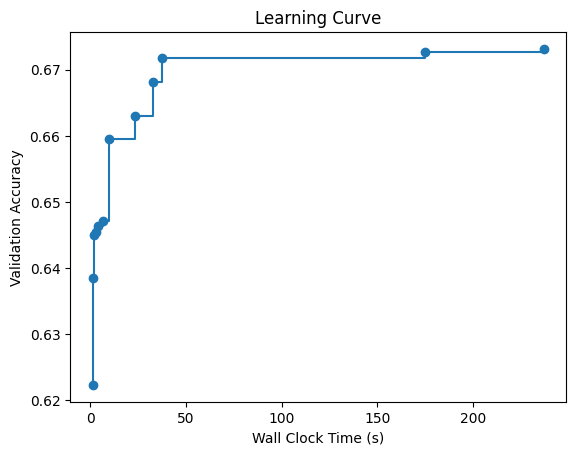

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives


### Default LightGBM

In [15]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [16]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [17]:
y_pred_lgbm = lgbm.predict(X_test)

### Default XGBoost

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_train_xgb = y_train.astype("int")

In [19]:
xgb.fit(X, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)
y_test_xgb = y_test.astype("int")


In [21]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test_xgb))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('flaml (10 min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6676060098186078
default lgbm accuracy = 0.6602346380315323
flaml (10 min) accuracy = 0.6732939797991784


## 4. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [22]:
%pip install rgf-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.automl.task.task import CLASSIFICATION


class MyRegularizedGreedyForest(SKLearnEstimator):
    def __init__(self, task='binary', **config):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary', 'multiclass', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''

        super().__init__(task, **config)

        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from rgf.sklearn import RGFClassifier

            self.estimator_class = RGFClassifier
        else:
            from rgf.sklearn import RGFRegressor
            
            self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {        
            'max_leaf': {'domain': tune.lograndint(lower=4, upper=data_size[0]), 'init_value': 4, 'low_cost_init_value': 4},
            'n_iter': {'domain': tune.lograndint(lower=1, upper=data_size[0]), 'init_value': 1, 'low_cost_init_value': 1},
            'n_tree_search': {'domain': tune.lograndint(lower=1, upper=32768), 'init_value': 1, 'low_cost_init_value': 1},
            'opt_interval': {'domain': tune.lograndint(lower=1, upper=10000), 'init_value': 100},
            'learning_rate': {'domain': tune.loguniform(lower=0.01, upper=20.0)},
            'min_samples_leaf': {'domain': tune.lograndint(lower=1, upper=20), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves * 3 + (max_leaves - 1) * 4 + 1.0) * n_estimators * 8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [24]:
automl = AutoML()
automl.add_learner(learner_name='RGF', learner_class=MyRegularizedGreedyForest)

In [25]:
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment_custom_learner.log',  # flaml log file 
    "log_training_metric": True,  # whether to log training metric
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 04-28 02:31:18] {1663} INFO - task = classification
[flaml.automl.logger: 04-28 02:31:18] {1670} INFO - Data split method: stratified
[flaml.automl.logger: 04-28 02:31:18] {1673} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-28 02:31:18] {1771} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-28 02:31:18] {1881} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl.logger: 04-28 02:31:18] {2191} INFO - iteration 0, current learner RGF
[flaml.automl.logger: 04-28 02:31:19] {2317} INFO - Estimated sufficient time budget=320931s. Estimated necessary time budget=321s.
[flaml.automl.logger: 04-28 02:31:19] {2364} INFO -  at 1.4s,	estimator RGF's best error=0.3840,	best estimator RGF's best error=0.3840
[flaml.automl.logger: 04-28 02:31:19] {2191} INFO - iteration 1, current learner RGF
[flaml.automl.logger: 04-28 02:31:19] {2364} INFO -  at 1.9s,	estimator RGF's best error=0.3840,	best estimator RGF's b

## 5. Customized Metric

It's also easy to customize the optimization metric. As an example, we demonstrate with a custom metric function which combines training loss and validation loss as the final loss to minimize.

In [26]:
def custom_metric(X_val, y_val, estimator, labels, X_train, y_train,
                  weight_val=None, weight_train=None, config=None,
                  groups_val=None, groups_train=None):
    from sklearn.metrics import log_loss
    import time
    start = time.time()
    y_pred = estimator.predict_proba(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = log_loss(y_val, y_pred, labels=labels,
                         sample_weight=weight_val)
    y_pred = estimator.predict_proba(X_train)
    train_loss = log_loss(y_train, y_pred, labels=labels,
                          sample_weight=weight_train)
    alpha = 0.5
    return val_loss * (1 + alpha) - alpha * train_loss, {
        "val_loss": val_loss, "train_loss": train_loss, "pred_time": pred_time
    }
    # two elements are returned:
    # the first element is the metric to minimize as a float number,
    # the second element is a dictionary of the metrics to log

We can then pass this custom metric function to automl's `fit` method.

In [27]:
automl = AutoML()
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": custom_metric,  # pass the custom metric funtion here
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment_custom_metric.log',  # flaml log file
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 04-28 02:31:59] {1663} INFO - task = classification
[flaml.automl.logger: 04-28 02:31:59] {1670} INFO - Data split method: stratified
[flaml.automl.logger: 04-28 02:31:59] {1673} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-28 02:31:59] {1771} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 04-28 02:31:59] {1881} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-28 02:31:59] {2191} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-28 02:31:59] {2317} INFO - Estimated sufficient time budget=13725s. Estimated necessary time budget=337s.
[flaml.automl.logger: 04-28 02:31:59] {2364} INFO -  at 0.5s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6647
[flaml.automl.logger: 04-28 02:31:59] {2191} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-28 02:31:59] {2364} INFO -  at 0.6s,	es

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 0.9s,	estimator lgbm's best error=0.6400,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 0.9s,	estimator lgbm's best error=0.6400,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 9, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 0.9s,	estimator xgboost's best error=0.6672,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 10, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.0s,	estimator xgboost's best error=0.6503,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 11, current learner extra_tree
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.0s,	estimator extra_tree's

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.1s,	estimator rf's best error=0.6614,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 14, current learner rf
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.2s,	estimator rf's best error=0.6523,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 15, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.3s,	estimator xgboost's best error=0.6428,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 16, current learner rf
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.3s,	estimator rf's best error=0.6523,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 17, current learner extra_tree
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.4s,	estimator extra_tree's best error=0.

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.4s,	estimator lgbm's best error=0.6400,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 19, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.5s,	estimator xgboost's best error=0.6428,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 20, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.5s,	estimator xgboost's best error=0.6428,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 21, current learner xgboost
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.6s,	estimator xgboost's best error=0.6428,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.6s,	estimator lgbm's bes

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:00] {2364} INFO -  at 1.7s,	estimator lgbm's best error=0.6400,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:00] {2191} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 1.8s,	estimator xgboost's best error=0.6428,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 1.8s,	estimator extra_tree's best error=0.6576,	best estimator lgbm's best error=0.6400
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 26, current learner lgbm
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 1.9s,	estimator lgbm's best error=0.6335,	best estimator lgbm's best error=0.6335
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 27, current learner xgboost


/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 2.0s,	estimator xgboost's best error=0.6423,	best estimator lgbm's best error=0.6335
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 28, current learner extra_tree
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 2.0s,	estimator extra_tree's best error=0.6480,	best estimator lgbm's best error=0.6335
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 29, current learner extra_tree
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 2.1s,	estimator extra_tree's best error=0.6480,	best estimator lgbm's best error=0.6335
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 30, current learner lgbm
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 2.2s,	estimator lgbm's best error=0.6335,	best estimator lgbm's best error=0.6335
[flaml.automl.logger: 04-28 02:32:01] {2191} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 04-28 02:32:01] {2364} INFO -  at 2.2s,	estimator l

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:04] {2364} INFO -  at 5.0s,	estimator lgbm's best error=0.6241,	best estimator lgbm's best error=0.6241
[flaml.automl.logger: 04-28 02:32:04] {2191} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 04-28 02:32:04] {2364} INFO -  at 5.4s,	estimator lgbm's best error=0.6206,	best estimator lgbm's best error=0.6206
[flaml.automl.logger: 04-28 02:32:04] {2191} INFO - iteration 49, current learner lgbm
[flaml.automl.logger: 04-28 02:32:05] {2364} INFO -  at 5.8s,	estimator lgbm's best error=0.6206,	best estimator lgbm's best error=0.6206
[flaml.automl.logger: 04-28 02:32:05] {2191} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 04-28 02:32:05] {2364} INFO -  at 6.2s,	estimator lgbm's best error=0.6206,	best estimator lgbm's best error=0.6206
[flaml.automl.logger: 04-28 02:32:05] {2191} INFO - iteration 51, current learner catboost
[flaml.automl.logger: 04-28 02:32:05] {2364} INFO -  at 6.5s,	estimator catboost's best error=0.

/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vscode/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 04-28 02:32:09] {2364} INFO -  at 10.1s,	estimator lrl1's best error=0.6817,	best estimator lgbm's best error=0.6156


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-28 02:32:10] {2600} INFO - retrain lgbm for 0.7s
[flaml.automl.logger: 04-28 02:32:10] {2603} INFO - retrained model: LGBMClassifier(colsample_bytree=0.9031374907114736,
               learning_rate=0.3525398690474661, max_bin=1023,
               min_child_samples=4, n_estimators=22, num_leaves=69,
               reg_alpha=0.0060777294606297145, reg_lambda=37.65858370595088,
               verbose=-1)
[flaml.automl.logger: 04-28 02:32:10] {1911} INFO - fit succeeded
[flaml.automl.logger: 04-28 02:32:10] {1912} INFO - Time taken to find the best model: 8.02491545677185
